# Final Project - Sea Level Rise
By: Jake Phelan, Mira Chadha, Douglas Read, and Kirti Magam

In [37]:
# imports
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import scipy.stats as scipstat
import seaborn as sns
sns.set() 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Exploratory Data Analysis  

In [2]:
from datetime import datetime as dt
import time

# Converts a date (year + month) into a decimal representation.
# Will be used to combine dataframes 
def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    # track start and end of year 
    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    # calculates time passed within year
    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    
    # converts month and day positioning of year to fraction for decimal date
    fraction = yearElapsed/yearDuration

    return date.year + fraction

# source: https://stackoverflow.com/questions/6451655/how-to-convert-python-datetime-dates-to-decimal-float-years

In [3]:
# Finds the closest rows [lower neighbor, upper neighbor] in a pandas series given a value, 
# a dataframe, and the column of interest. If an exact match is found or there is no upper neighbor, only returns lower neighbor
def find_neighbours(value, df, colname):
    try:
        lowerneighbour_ind = df[df[colname] < value][colname].idxmax()
        upperneighbour_ind = df[df[colname] > value][colname].idxmin()
        return [lowerneighbour_ind, upperneighbour_ind] 
    except ValueError:
        # For our use case, use the lower neighbor if upper does not exist 
        return [df[df[colname] < value][colname].idxmax(), df[df[colname] < value][colname].idxmax()]

# source: https://stackoverflow.com/questions/30112202/how-do-i-find-the-closest-values-in-a-pandas-series-to-an-input-number

### EDA for Sea Level Rise Data
[Dictionary/Source of Data](https://www.star.nesdis.noaa.gov/socd/lsa/SeaLevelRise/)

In [4]:
# read the csv using the standard delimeter and ignoring lines that are commented (#)
searise_df = pd.read_csv("slr_sla_gbl_keep_txj1j2_90.csv", comment="#")

# convert columns to desired type
searise_df = searise_df.astype({'year':'float', 'TOPEX/Poseidon':'float', 'Jason-1':'float',
                'Jason-2':'float', 'Jason-3':'float'})

# create an average for each measurement based on the amount of data available and save as a column
aves = []
searise_df.fillna(0, inplace=True)
for row in range(len(searise_df)):
    aves.append(sum(list(searise_df.iloc[row][1:5])) / (4 - list(searise_df.iloc[row][1:5]).count(0)))
searise_df['Sea Level Rise'] = aves

# drop the specific sources of measurements - only interested in average of rise
searise_df.drop(columns=['TOPEX/Poseidon', 'Jason-1', 'Jason-2', 'Jason-3'], inplace=True)

In [5]:
# Integrity Checks on Dataframe 

# esure the correct amount of data
print("Correct Number of Rows and Columns:")
print((1345, 2) == searise_df.shape)

# ensure correct datatypes
print("\nDatatypes of Searise Df:")
print(searise_df.dtypes)

# print the head to analyze 
searise_df.head(10)

Correct Number of Rows and Columns:
True

Datatypes of Searise Df:
year              float64
Sea Level Rise    float64
dtype: object


,year,Sea Level Rise
0,1992.9614,-16.06
1,1992.9865,-17.76
2,1993.0123,-14.66
3,1993.0407,-19.66
4,1993.0660,-25.06
5,1993.0974,-29.16
6,1993.1206,-27.46
7,1993.1493,-21.66
8,1993.1765,-18.76
9,1993.2037,-19.26


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


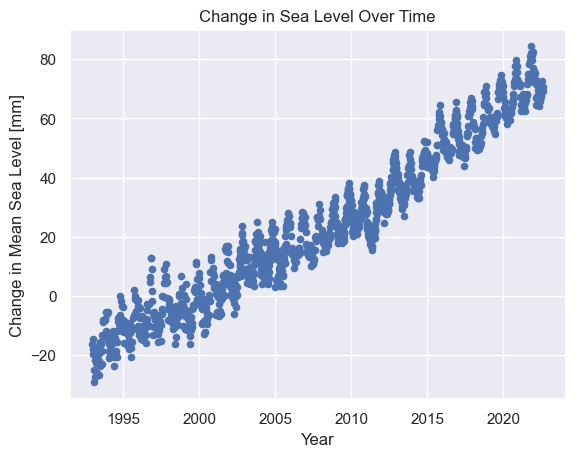

In [6]:
# Crude analysis of relatioship
searise_df.plot(kind="scatter", 
                x="year", 
                y="Sea Level Rise",
                xlabel="Year",
                ylabel="Change in Mean Sea Level [mm]",
                title="Change in Sea Level Over Time")

plt.show()

As is seen from the relationship above, this data shows a clear increase in sea-level rise over time.

### EDA for CO2 Data
[Dictionary/Source of Data](https://gml.noaa.gov/ccgg/trends/gl_data.html)

In [7]:
# read from csv 
CO2_df = pd.read_csv("co2_mm_gl.csv", comment="#")

# drop year and month columns from df using decimal based year
CO2_df.drop(columns=['year','month'], inplace=True)

# rename the columns 
CO2_df.rename(columns={'decimal': 'year',
                       'average': 'Average CO2',
                       'average_unc': 'CO2 UNC Average',
                       'trend': 'CO2 Trend',
                       'trend_unc': 'CO2 UNC Trend'}, 
              inplace=True)

# drop data that starts before available sea-level data
CO2_df = CO2_df[167:].reset_index(drop=True)

In [8]:
# Integrity Checks on Dataframe 

# esure the correct amount of data
print("Correct Number of Rows and Columns:")
print((357, 5) == CO2_df.shape)

# ensure correct datatypes
print("\nDatatypes of Searise Df:")
print(CO2_df.dtypes)

# print the head to analyze 
CO2_df.head(10)

Correct Number of Rows and Columns:
True

Datatypes of Searise Df:
year               float64
Average CO2        float64
CO2 UNC Average    float64
CO2 Trend          float64
CO2 UNC Trend      float64
dtype: object


,year,Average CO2,CO2 UNC Average,CO2 Trend,CO2 UNC Trend
0,1992.958,356.74,0.10,356.27,0.07
1,1993.042,357.21,0.10,356.37,0.07
2,1993.125,357.55,0.10,356.40,0.07
3,1993.208,357.96,0.10,356.52,0.07
4,1993.292,358.43,0.10,356.66,0.07
5,1993.375,358.38,0.14,356.73,0.07
6,1993.458,357.34,0.11,356.68,0.07
7,1993.542,355.72,0.15,356.74,0.07
8,1993.625,354.44,0.15,356.91,0.07
9,1993.708,354.47,0.08,357.05,0.07


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


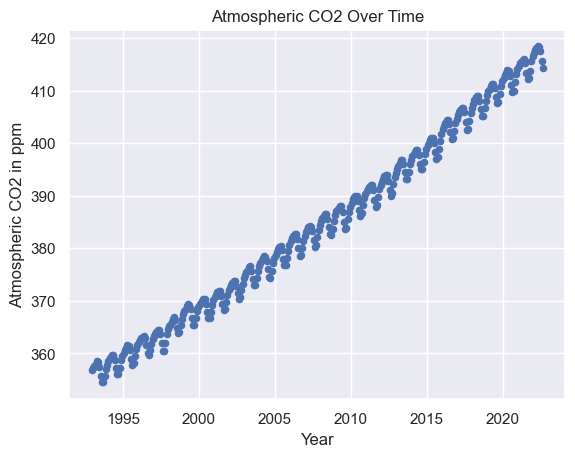

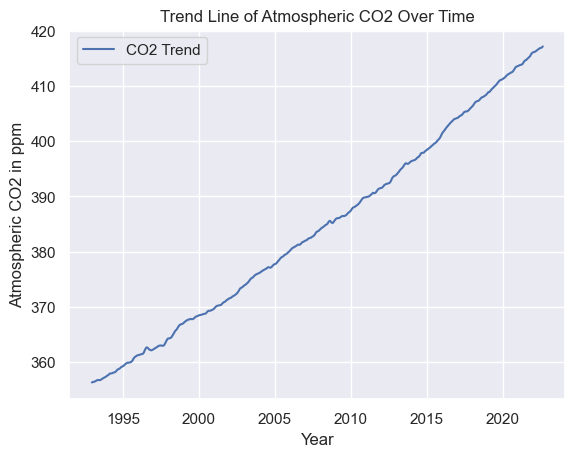

In [9]:
# Crude analysis of relationships from data 

# Analyze the relationship between time and atmospheric CO2
CO2_df.plot(kind="scatter", 
            x="year", 
            y="Average CO2",
            xlabel="Year",
            ylabel="Atmospheric CO2 in ppm",
            title="Atmospheric CO2 Over Time")
plt.show()

CO2_df.plot(kind="line", 
            x="year", 
            y="CO2 Trend",
            xlabel="Year",
            ylabel="Atmospheric CO2 in ppm",
            title="Trend Line of Atmospheric CO2 Over Time")
plt.show()

As is seen in the charts above, there is a clear positive relationship between atmospheric CO2 and time. This is a liner-appearing positive trend overall, but there is fluctuations at the granularity of months.

### EDA for Climatological Data
[Dictionary/Source of Data](https://www.ncei.noaa.gov/cdo-web/datatools/lcd)

In [10]:
# read in climatological csv
df = pd.read_csv('climatological_data_96_22.csv')

# drop the unnecessary columns
# those with large amounts of missing data or no obvious relation to Sea-Level Rise based on prior knowledge
df.drop(columns=['Unnamed: 0', 'STATION', 'REPORT_TYPE', 'SOURCE', 'BackupDirection',
                 'BackupDistance', 'BackupDistanceUnit', 'BackupElements', 'BackupElevation',
                 'BackupEquipment', 'BackupLatitude', 'BackupLongitude', 'BackupName', 
                 'DailyAverageDewPointTemperature', 'DailyAverageRelativeHumidity', 
                 'DailyAverageSeaLevelPressure', 'DailyAverageWetBulbTemperature', 
                 'DailyAverageWindSpeed', 'DailyCoolingDegreeDays', 'DailyHeatingDegreeDays',
                 'DailyPeakWindDirection', 'DailyPeakWindSpeed', 'DailySnowDepth', 'DailySnowfall',
                 'DailySustainedWindDirection', 'DailySustainedWindSpeed', 'DailyWeather', 'REM',
                 'REPORT_TYPE.1', 'SOURCE.1', 'Sunrise', 'Sunset', 'WindEquipmentChangeDate'
                ], inplace=True)

# convert date column to the desired representation of decimal year
df['DATE'] = pd.to_datetime(df['DATE'])
df['DATE'] = [toYearFraction(x) for x in list(df['DATE'])]
df.rename(columns={'DATE':'year'}, inplace=True)

In [11]:
# Integrity Checks on Dataframe 

# esure the correct amount of data
print("Correct Number of Rows and Columns:")
print((9507, 7) == df.shape)

# ensure correct datatypes
print("\nDatatypes of Searise Df:")
print(df.dtypes)

# print percent of missing data
print("\nPercent of Missing Data:")
print(df.isnull().mean() * 100)

# print the head to analyze 
df.head(10)

Correct Number of Rows and Columns:
True

Datatypes of Searise Df:
year                                          float64
DailyAverageDryBulbTemperature                 object
DailyAverageStationPressure                   float64
DailyDepartureFromNormalAverageTemperature     object
DailyMaximumDryBulbTemperature                 object
DailyMinimumDryBulbTemperature                 object
DailyPrecipitation                             object
dtype: object

Percent of Missing Data:
year                                          0.000000
DailyAverageDryBulbTemperature                0.084149
DailyAverageStationPressure                   0.094667
DailyDepartureFromNormalAverageTemperature    0.084149
DailyMaximumDryBulbTemperature                0.084149
DailyMinimumDryBulbTemperature                0.073630
DailyPrecipitation                            0.000000
dtype: float64


,year,DailyAverageDryBulbTemperature,DailyAverageStationPressure,DailyDepartureFromNormalAverageTemperature,DailyMaximumDryBulbTemperature,DailyMinimumDryBulbTemperature,DailyPrecipitation
0,1996.499884,73s,29.74,21.9s,86,60s,0.01s
1,1996.502616,74,29.66,22.6,81,66,0
2,1996.505349,69,29.49,17.3,73,64,0.06
3,1996.508081,70,29.43,18,77,63,0.4
4,1996.510813,74,29.73,21.6,84,63,T
5,1996.513545,77,29.81,24.3,88,65,0.00s
6,1996.516278,70,29.80,17,75,65,0.00s
7,1996.519010,77,29.57,23.7,89,64,0.00s
8,1996.521742,77,29.56,23.4,86,68,0.12
9,1996.524474,73,29.80,19,80,65,0.00s


From the above, it is clear that there are datatype issues. DailyAverageDryBulbTemperature, DailyMaximumDryBulbTemperature, and DailyMinimumDryBulbTemperature should all be ints. DailyDepartureFromNormalAverageTemperature and DailyPrecipitation should be floats. More analysis is necessary to rectify these. 

In [12]:
# First, for missing values, there seems to be a pattern, so let's drop rows with more than 2 columns missing. 
df = df[df.isnull().sum(axis=1) < 2]

# reanalyze missing data
print("\nPercent of Missing Data:")
print(df.isnull().mean() * 100)


Percent of Missing Data:
year                                          0.000000
DailyAverageDryBulbTemperature                0.000000
DailyAverageStationPressure                   0.094747
DailyDepartureFromNormalAverageTemperature    0.000000
DailyMaximumDryBulbTemperature                0.000000
DailyMinimumDryBulbTemperature                0.000000
DailyPrecipitation                            0.000000
dtype: float64


In [13]:
# For the remaining missing data, we will impute the mean for DailyAverageStationPressure
mean_pressure = df["DailyAverageStationPressure"].mean()
df["DailyAverageStationPressure"].fillna(mean_pressure, inplace=True)

In [14]:
# From the head of the data it appears there is an input issue where some data has an 's' appended on it. 
# Let's investigate if this is common
print("Value Counts of DailyAverageDryBulbTemperature:\n", df["DailyAverageDryBulbTemperature"].value_counts())
print("Value Counts of DailyMaximumDryBulbTemperature:\n", df["DailyMaximumDryBulbTemperature"].value_counts())
print("Value Counts of DailyMinimumDryBulbTemperature:\n", df["DailyMinimumDryBulbTemperature"].value_counts())
print("Value Counts of DailyDepartureFromNormalAverageTemperature:\n", df["DailyDepartureFromNormalAverageTemperature"].value_counts())
print("Value Counts of DailyPrecipitation:\n", df["DailyPrecipitation"].value_counts())

Value Counts of DailyAverageDryBulbTemperature:
 68     217
67     211
41     196
71     192
38     191
      ... 
17s      1
44s      1
28s      1
84s      1
91       1
Name: DailyAverageDryBulbTemperature, Length: 143, dtype: int64
Value Counts of DailyMaximumDryBulbTemperature:
 73     197
72     190
60     188
43     186
50     184
      ... 
65s      1
84s      1
22s      1
103      1
10       1
Name: DailyMaximumDryBulbTemperature, Length: 97, dtype: int64
Value Counts of DailyMinimumDryBulbTemperature:
 63     232
34     223
62     215
59     214
65     211
      ... 
-12      1
33s      1
17s      1
22s      1
83       1
Name: DailyMinimumDryBulbTemperature, Length: 139, dtype: int64
Value Counts of DailyDepartureFromNormalAverageTemperature:
 -0.8      84
1.2       71
0.2       71
2.2       66
-2.8      65
          ..
10.3s      1
6.7s       1
-10.1s     1
-0.6s      1
23.1       1
Name: DailyDepartureFromNormalAverageTemperature, Length: 582, dtype: int64
Value Counts of Dai

In [15]:
# Clearly this issue with erroneous "s" effects all of these rows. First let's remove it. 
df["DailyAverageDryBulbTemperature"] = df["DailyAverageDryBulbTemperature"].astype("string").map(lambda x: x.rstrip("s"))
df["DailyMaximumDryBulbTemperature"] = df["DailyMaximumDryBulbTemperature"].astype("string").map(lambda x: x.rstrip("s"))
df["DailyMinimumDryBulbTemperature"] = df["DailyMinimumDryBulbTemperature"].astype("string").map(lambda x: x.rstrip("s"))
df["DailyDepartureFromNormalAverageTemperature"] = df["DailyDepartureFromNormalAverageTemperature"].astype("string").map(lambda x: x.rstrip("s"))
df["DailyPrecipitation"] = df["DailyPrecipitation"].astype("string").map(lambda x: x.rstrip("s"))

# We also need to account for the value T in DailyPrecipitation
# For these values, we will assume the mode of 0 to impute
df["DailyPrecipitation"] = df["DailyPrecipitation"].replace("T", "0")

# Next, let's convert them to the correct type. For missing value, impute the mode. 
df["DailyAverageDryBulbTemperature"] = df["DailyAverageDryBulbTemperature"].astype("int64")
df["DailyMaximumDryBulbTemperature"] = df["DailyMaximumDryBulbTemperature"].astype("int64")
df["DailyMinimumDryBulbTemperature"] = df["DailyMinimumDryBulbTemperature"].astype("int64")
df["DailyDepartureFromNormalAverageTemperature"] = df["DailyDepartureFromNormalAverageTemperature"].astype("float64")
df["DailyPrecipitation"] = df["DailyPrecipitation"].astype("float64")

In [16]:
# Redoing these checks which should all now pass

# esure the correct amount of data
print("Correct Number of Rows and Columns:")
print((9507, 7) == df.shape)

# ensure correct datatypes
print("\nDatatypes of Searise Df:")
print(df.dtypes)

# print percent of missing data
print("\nPercent of Missing Data:")
print(df.isnull().mean() * 100)

# print the head to analyze 
df.head(10)

Correct Number of Rows and Columns:
False

Datatypes of Searise Df:
year                                          float64
DailyAverageDryBulbTemperature                  int64
DailyAverageStationPressure                   float64
DailyDepartureFromNormalAverageTemperature    float64
DailyMaximumDryBulbTemperature                  int64
DailyMinimumDryBulbTemperature                  int64
DailyPrecipitation                            float64
dtype: object

Percent of Missing Data:
year                                          0.0
DailyAverageDryBulbTemperature                0.0
DailyAverageStationPressure                   0.0
DailyDepartureFromNormalAverageTemperature    0.0
DailyMaximumDryBulbTemperature                0.0
DailyMinimumDryBulbTemperature                0.0
DailyPrecipitation                            0.0
dtype: float64


,year,DailyAverageDryBulbTemperature,DailyAverageStationPressure,DailyDepartureFromNormalAverageTemperature,DailyMaximumDryBulbTemperature,DailyMinimumDryBulbTemperature,DailyPrecipitation
0,1996.499884,73,29.74,21.9,86,60,0.01
1,1996.502616,74,29.66,22.6,81,66,0.00
2,1996.505349,69,29.49,17.3,73,64,0.06
3,1996.508081,70,29.43,18.0,77,63,0.40
4,1996.510813,74,29.73,21.6,84,63,0.00
5,1996.513545,77,29.81,24.3,88,65,0.00
6,1996.516278,70,29.80,17.0,75,65,0.00
7,1996.519010,77,29.57,23.7,89,64,0.00
8,1996.521742,77,29.56,23.4,86,68,0.12
9,1996.524474,73,29.80,19.0,80,65,0.00


### Combine Dataframes and Analysis of Potential Relationships

In [17]:
# create columnns for sea level and CO2 data 
df['Sea Level Rise'] = [0]*len(df)
df['Average CO2'] = [0]*len(df)

searise_list = []
CO2_list = []

# fill in values for sea level and CO2 by matching the closest possible 
for index,row in df.iterrows():
    try:
        searise_neighbors = find_neighbours(row['year'], searise_df, 'year')
        searise_list.append(0.5*searise_df['Sea Level Rise'][searise_neighbors[0]] + 0.5*searise_df['Sea Level Rise'][searise_neighbors[1]])
    except ValueError:
        searise_list.append(None)

    try:
        CO2_neighbors = find_neighbours(row['year'], CO2_df, 'year')
        CO2_list.append(0.5*CO2_df['Average CO2'][CO2_neighbors[0]] + 0.5*CO2_df['Average CO2'][CO2_neighbors[1]])
    except: 
        CO2_list.append(None)
        pass

df['Sea Level Rise'] = searise_list
df['Average CO2'] = CO2_list

In [18]:
# Ensure there is no missing data
print("Missing Sea Level Rise data?", 0 < df['Sea Level Rise'].isna().sum())
print("Missing Average CO2 data?", 0 < df['Average CO2'].isna().sum())

Missing Sea Level Rise data? False
Missing Average CO2 data? False


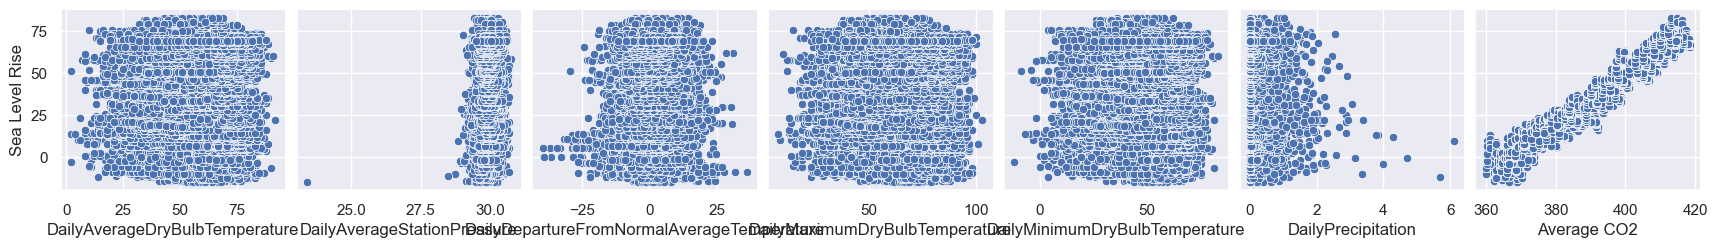

In [19]:
# Now, we can analyze some relationships of interest. 

# Crude analysis of potential features on x-axis with variable of interest (Sea Level Rise) on y-axis 
sns.pairplot(df,
             x_vars=["DailyAverageDryBulbTemperature", "DailyAverageStationPressure", "DailyDepartureFromNormalAverageTemperature", "DailyMaximumDryBulbTemperature", "DailyMinimumDryBulbTemperature", "DailyPrecipitation", "Average CO2"],
             y_vars=["Sea Level Rise"],
             )
plt.show()

From this analysis, it is clear that CO2 is a useful feature in predicting Sea Level Rise. Though the other features contain considerable noise, there seems to be minor indications that Precipitation and temperature can have effects (in addition to theoretical intuitions that these might be explanatory). Due to this, we will consider the following features: Average CO2, DailyAverageDryBulbTemperature, DailyDepartureFromNormalAverageTemperature, and DailyPrecipitation. 

## Data Partitioning and Normalization

In [20]:
# Data partitioning
X = df[["Average CO2", 
        "DailyAverageDryBulbTemperature", 
        "DailyDepartureFromNormalAverageTemperature", 
        "DailyPrecipitation"]]
y = df["Sea Level Rise"]

# Do a train-test split to split data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,  # set aside 30% of data for testing
                                                    random_state=7  # use a set random state for reproducability
                                                   )

In [21]:
# Standardize numeric variables
# pre-scaled data 
print("Pre-scaled features:")
print(X_train.head())

scaler = StandardScaler()
scaler.fit(X_train[["Average CO2", 
                    "DailyAverageDryBulbTemperature", 
                    "DailyDepartureFromNormalAverageTemperature", 
                    "DailyPrecipitation"]])

X_train[["Average CO2", 
         "DailyAverageDryBulbTemperature", 
         "DailyDepartureFromNormalAverageTemperature", 
         "DailyPrecipitation"]] = scaler.transform(X_train[["Average CO2", 
                                                            "DailyAverageDryBulbTemperature", 
                                                            "DailyDepartureFromNormalAverageTemperature", 
                                                            "DailyPrecipitation"]])

X_test[["Average CO2", 
        "DailyAverageDryBulbTemperature", 
        "DailyDepartureFromNormalAverageTemperature", 
        "DailyPrecipitation"]] = scaler.transform(X_test[["Average CO2", 
                                                          "DailyAverageDryBulbTemperature", 
                                                          "DailyDepartureFromNormalAverageTemperature", 
                                                          "DailyPrecipitation"]])

# Ensure Changes Took Place
print("Pre-scaled features:")
print(X_train.head())

Pre-scaled features:
      Average CO2  DailyAverageDryBulbTemperature  \
8156      411.125                              42   
9306      418.415                              71   
6689      400.345                              36   
6053      395.215                              65   
2184      372.615                              37   

      DailyDepartureFromNormalAverageTemperature  DailyPrecipitation  
8156                                         2.5                0.88  
9306                                        13.7                0.01  
6689                                        -1.8                0.00  
6053                                        -3.3                0.63  
2184                                       -10.6                0.00  
Pre-scaled features:
      Average CO2  DailyAverageDryBulbTemperature  \
8156     1.374235                       -0.637223   
9306     1.821055                        1.053152   
6689     0.713504                       -0.986955   
6

## Approach #1 KNN-Regressor

In [22]:
# create the KNN-regressor
knr = KNeighborsRegressor(n_neighbors=5)

In [23]:
# Fit the data 
knr.fit(X_train, y_train)

KNeighborsRegressor()

In [24]:
# predict the y values 
y_pred = knr.predict(X_test)

In [25]:
# Score the model (accuracy)
print("Accuracy: ", round(knr.score(X_test, y_test), 2))

Accuracy:  0.92


### Hyper-parameter Tuning 

In [26]:
# tuning parameters with grid search
knr_param_grid = {
    'n_neighbors': np.arange(1, 100),
}

knr_grid = GridSearchCV(estimator = knr, param_grid = knr_param_grid, cv=5, return_train_score = True, n_jobs=5) 
knr_grid.fit(X_train, y_train)

print(knr_grid.best_params_) #print the best parameters
print(knr_grid.best_score_)  #print the best score

{'n_neighbors': 24}
0.92205198547572


In [27]:
# display the cv results for the train and test set
cv_results = pd.DataFrame(knr_grid.cv_results_)
cv_results = cv_results.sort_values('mean_test_score', ascending=False)
cv_results[['mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']].head()

,mean_train_score,std_train_score,mean_test_score,std_test_score
23,0.928269,0.000422,0.922052,0.003291
17,0.930459,0.000725,0.922008,0.003620
19,0.929706,0.000640,0.921921,0.003517
20,0.929340,0.000634,0.921902,0.003323
22,0.928599,0.000522,0.921902,0.003290


## Approach #2 Random Forest Regressor

In [28]:
# create the Random Forest (Regressor)
rfr = RandomForestRegressor(n_estimators=100)

In [29]:
# Fit the data 
rfr.fit(X_train, y_train)

RandomForestRegressor()

In [30]:
# predict the y values 
y_pred = rfr.predict(X_test)

In [31]:
# Score the model (accuracy)
print("Accuracy: ", round(rfr.score(X_test, y_test), 2))

Accuracy:  0.99


### Hyper-parameter Tuning 

In [32]:
# tuning parameters with grid search
rfr_param_grid = {
    'n_estimators': np.array([25, 50, 100, 200, 400]),
    'max_depth': np.array([None, 1, 3, 5, 7]),
}

rfr_grid = GridSearchCV(estimator = rfr, param_grid = rfr_param_grid, cv=5, return_train_score = True, n_jobs=5) 
rfr_grid.fit(X_train, y_train)

print(rfr_grid.best_params_) #print the best parameters
print(rfr_grid.best_score_)  #print the best score

{'max_depth': None, 'n_estimators': 200}
0.9931470666450333


In [34]:
# display the cv results for the train and test set
cv_results = pd.DataFrame(rfr_grid.cv_results_)
cv_results = cv_results.sort_values('mean_test_score', ascending=False)
cv_results[['mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']].head()

,mean_train_score,std_train_score,mean_test_score,std_test_score
3,0.999025,0.000012,0.993147,0.000142
4,0.999031,0.000018,0.993115,0.000148
1,0.998933,0.000038,0.992915,0.000296
2,0.998983,0.000020,0.992909,0.000282
0,0.998786,0.000045,0.992731,0.000264


## Approach #3  Support Vector Machine Regressor

In [39]:
# create the Support Vector Machine (Regressor)
svm = SVR(cache_size=1000)

In [40]:
# Fit the data 
svm.fit(X_train, y_train)

SVR(cache_size=1000)

In [41]:
# predict the y values 
y_pred = svm.predict(X_test)

In [42]:
# Score the model (accuracy)
print("Accuracy: ", round(svm.score(X_test, y_test), 2))

Accuracy:  0.91


### Hyper-parameter Tuning 

In [43]:
# tuning parameters using grid search
svm_param_grid = {
    'C': np.arange(1, 10),
    'gamma': np.arange(1, 5)
}

svm_grid = GridSearchCV(estimator = svm, param_grid = svm_param_grid, cv=5, return_train_score = True, n_jobs=5) 
svm_grid.fit(X_train, y_train)

print(svm_grid.best_params_) #print the best parameters
print(svm_grid.best_score_)  #print the best score

{'C': 9, 'gamma': 1}
0.9142035532287636


In [44]:
# display the cv results for the train and test set
cv_results = pd.DataFrame(svm_grid.cv_results_)
cv_results = cv_results.sort_values('mean_test_score', ascending=False)
cv_results[['mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']].head()

,mean_train_score,std_train_score,mean_test_score,std_test_score
32,0.929931,0.000623,0.914204,0.003760
28,0.928936,0.000639,0.913762,0.003755
24,0.927689,0.000710,0.913126,0.003811
20,0.926116,0.000796,0.912231,0.003915
16,0.924118,0.000847,0.910934,0.004099


### Further Analysis after Hyperparameter Tuning for the Models

KNN Model:

In [49]:
# create the KNN-regressor
knr = KNeighborsRegressor(n_neighbors=24)

# Fit the data 
knr.fit(X_train, y_train)

# predict the y values 
y_pred = knr.predict(X_test)

In [50]:
# calculating MSE 
mse = mean_squared_error(y_test, y_pred)

# Evaluate the Predictions
print('The mse of the model is: {}'.format(round(mse, 2)))

The mse of the model is: 46.98


Random Forest Model:

In [51]:
# choosing 200 estimators based on hyperparameter tuning 
rfr = RandomForestRegressor(max_depth=None, n_estimators=200)

# Fit the data 
rfr.fit(X_train, y_train)

# predict the y values 
y_pred = rfr.predict(X_test)

In [52]:
# calculating MSE 
mse = mean_squared_error(y_test, y_pred)

# Evaluate the Predictions
print('The mse of the model is: {}'.format(round(mse, 2)))

The mse of the model is: 3.73


SVM Model:

In [53]:
# create the Support Vector Machine (Regressor)
svm = SVR(C=9, gamma=1, cache_size=1000)

# Fit the data 
svm.fit(X_train, y_train)

# predict the y values 
y_pred = svm.predict(X_test)

In [54]:
# calculating MSE 
mse = mean_squared_error(y_test, y_pred)

# Evaluate the Predictions
print('The mse of the model is: {}'.format(round(mse, 2)))

The mse of the model is: 52.49


The Random Forest Regression Model has the lowest MSE value after the models were hyperparameter tuned and it had the highest accuracy score, showing that it was the strongest model of the three. 